# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. RANDRIANANDRAINA Jessica №01
2. DIMBIMALALA Fanorenana  №28
3. RAZANANIRINA Felana Natalia  №29 
4. MAHATAMBELONIRINA Jessica Tinah  №30
5. MIHANTAHARISOA Solange  №31
6. RAZAFINDRAHANIRAKA fitahiana Henintsoa  №61


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

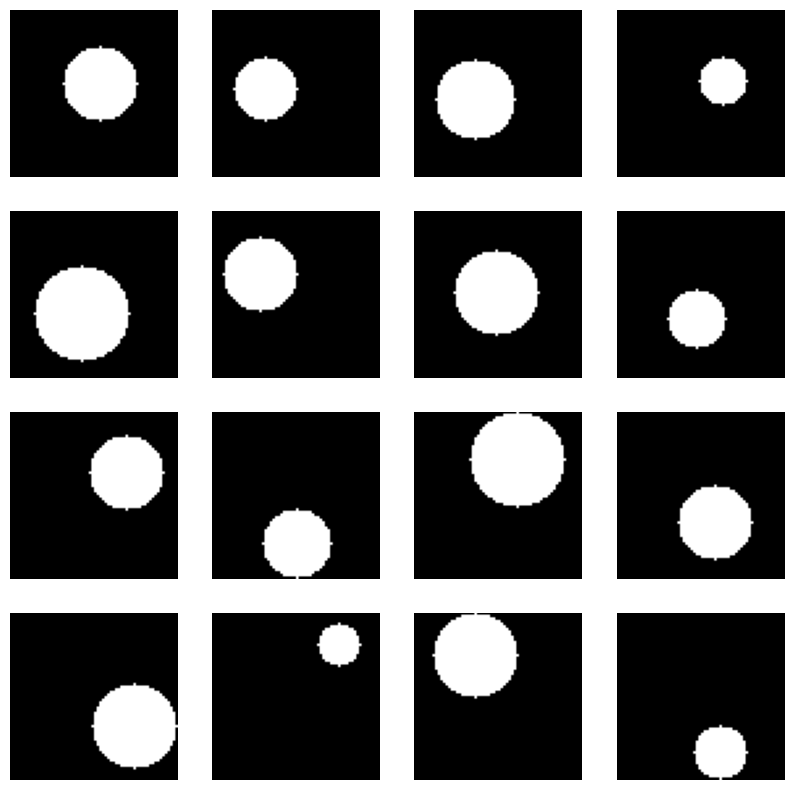

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [41]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [ ]:
1. Pour le test de ce modèle sur des images d'entrées imparfaites, nous avons choisi comme imperfections d'ajouter des bruits
INTERPRETATION:
Modèle entièrement connecté:
Il peut avoir des difficultés à reconstruire correctement les images bruitées car il ne capture pas les relations spatiales entre les pixels.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 3)              │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 64, 64, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.5184 - val_loss: 0.3762
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3659 - val_loss: 0.3514
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3491 - val_loss: 0.3451
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3439 - val_loss: 0.3402
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3395 - val_loss: 0.3368
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3364 - val_loss: 0.3355
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3344 - val_loss: 0.3336
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3328 - val_loss: 0.3327
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3317 - val_loss: 0.3316
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3308 - val_loss: 0.3310
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3293 - val_loss: 0.3302
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3

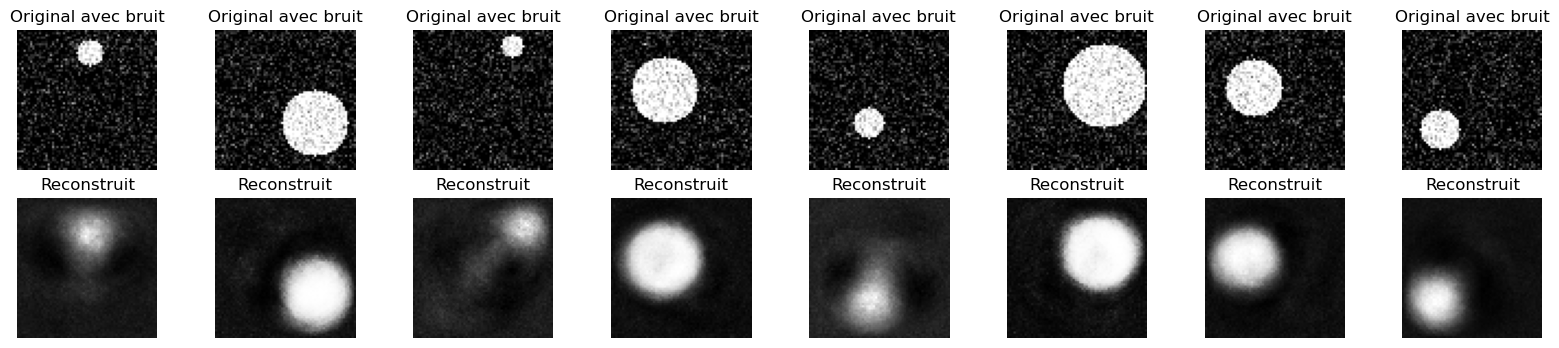

In [43]:



import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


# Fonction pour ajouter du bruit à une image
def add_noise(image, noise_factor=0.2):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)  # Limiter les valeurs entre 0 et 1
    return noisy_image

# Générer une image avec un cercle
def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    radius = np.random.randint(min_radius, max_radius)
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)
    cv2.circle(image, (x, y), radius, 255, -1)
    image = image.astype('float32') / 255.0
    return image

# Générer le dataset
def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    data = np.expand_dims(data, axis=-1)
    return data

# Charger les données
train_data = generate_dataset(n_samples=10000, image_size=64)
test_data = generate_dataset(n_samples=2000, image_size=64)

# Ajouter du bruit aux données
noisy_train_data = np.array([add_noise(img) for img in train_data])
noisy_test_data = np.array([add_noise(img) for img in test_data])

# Créer le modèle autoencodeur entièrement connecté
input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

# Compiler le modèle
autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()

# Entraîner le modèle avec les données bruitées
history_fc = autoencoder_fc.fit(noisy_train_data, noisy_train_data,
                                epochs=20,
                                batch_size=128,
                                shuffle=True,
                                validation_data=(noisy_test_data, noisy_test_data))

# Faire des prédictions sur les données bruitées
decoded_imgs_fc = autoencoder_fc.predict(noisy_test_data)

# Afficher les résultats
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale avec bruit
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_data[i].squeeze(), cmap='gray')
    plt.title('Original avec bruit')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()



### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [22]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4735 - val_loss: 0.1692
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1490 - val_loss: 0.1136
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1061 - val_loss: 0.0909
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0877 - val_loss: 0.0809
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0801 - val_loss: 0.0772
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0758 - val_loss: 0.0743
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0728 - val_loss: 0.0717
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0704 - val_loss: 0.0699
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0686 - val_loss: 0.0688
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0666 - val_loss: 0.0670
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0651 - val_loss: 0.0660
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


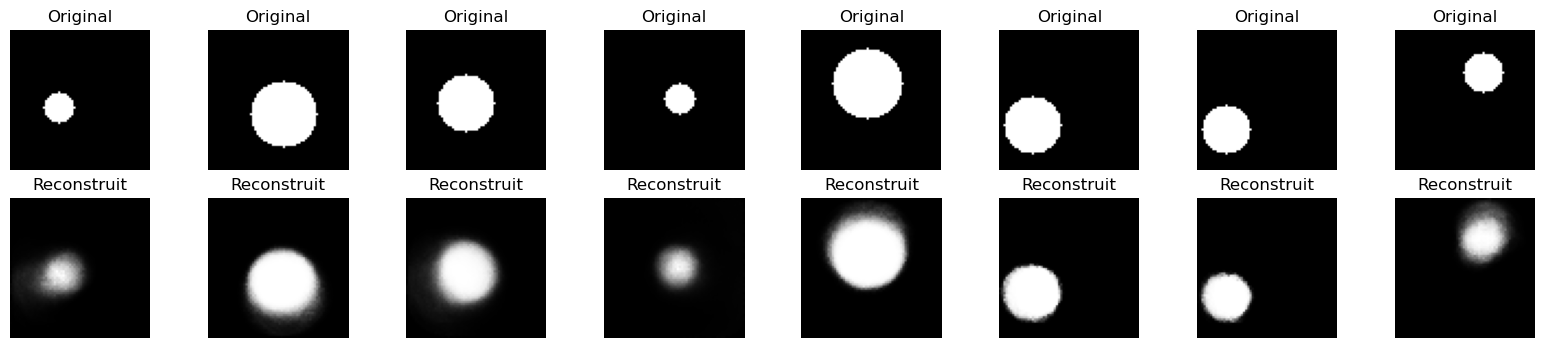

In [27]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [ ]:
1. Pour le test de ce modèle sur des images d'entrées imparfaites, nous avons choisi comme imperfections d'ajouter des bruits
INTERPRETATION:
Modèle convolutionnel:
Les convolutions et la réduction de dimension permettent de mieux gérer les variations locales dans les images, rendant ainsi ce modèle plus robuste aux bruits

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.2510 - val_loss: 0.1847
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.1832 - val_loss: 0.1752
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - loss: 0.1762 - val_loss: 0.1720
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.1734 - val_loss: 0.1700
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.1710 - val_loss: 0.1684
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - loss: 0.1702 - val_loss: 0.1677
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.1698 - val_loss: 0.1675
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.1685 - val_loss: 0.1670
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.1683 - val_loss: 0.1663
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.1677 - val_loss: 0.1657
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


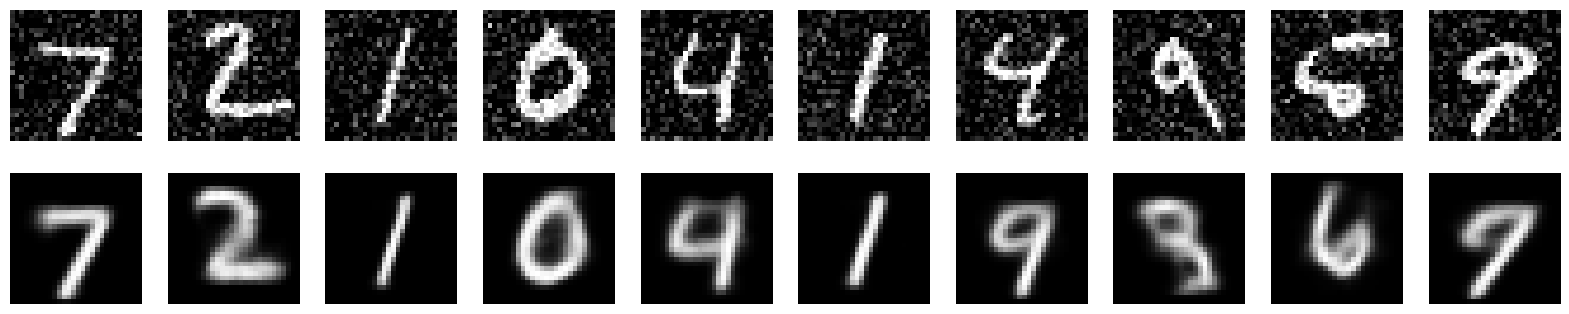

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GaussianNoise

# Fonction pour ajouter du bruit manuellement
def add_noise(image, noise_factor=0.2):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0.0, 1.0)  # Limiter entre 0 et 1

# Chargement de données (exemple avec MNIST pour démonstration)
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
train_data = train_data.astype("float32") / 255.0
test_data = test_data.astype("float32") / 255.0

# Reshape pour être compatible avec le modèle CNN
train_data = np.expand_dims(train_data, axis=-1)  # (60000, 28, 28, 1)
test_data = np.expand_dims(test_data, axis=-1)    # (10000, 28, 28, 1)

# Ajout de bruit aux images
noisy_train_data = np.array([add_noise(img) for img in train_data])
noisy_test_data = np.array([add_noise(img) for img in test_data])

# Définition du modèle avec une couche GaussianNoise
input_img = layers.Input(shape=(28, 28, 1))  # 28x28 au lieu de 64x64 pour MNIST

noisy_input = GaussianNoise(0.2)(input_img)  # Ajout du bruit dans le modèle
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(noisy_input)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

x = layers.Dense(7*7*64, activation='relu')(latent)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement du modèle sur les images bruitées
autoencoder_conv.fit(noisy_train_data, train_data, epochs=10, batch_size=32, validation_data=(noisy_test_data, test_data))

# Test du modèle sur des images bruitées
decoded_imgs = autoencoder_conv.predict(noisy_test_data)

# Affichage des résultats
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Image bruitée
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(noisy_test_data[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Image reconstruite
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()


### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [35]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - loss: 0.5432 - val_loss: 0.3135
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - loss: 0.3090 - val_loss: 0.2830
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 0.2284 - val_loss: 0.1301
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 0.1054 - val_loss: 0.0740
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 0.0687 - val_loss: 0.0521
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - loss: 0.0477 - val_loss: 0.0376
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 0.0370 - val_loss: 0.0320
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - loss: 0.0309 - val_loss: 0.0294
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - loss: 0.0275 - val_loss: 0.0249
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - loss: 0.0222 - val_loss: 0.0216
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


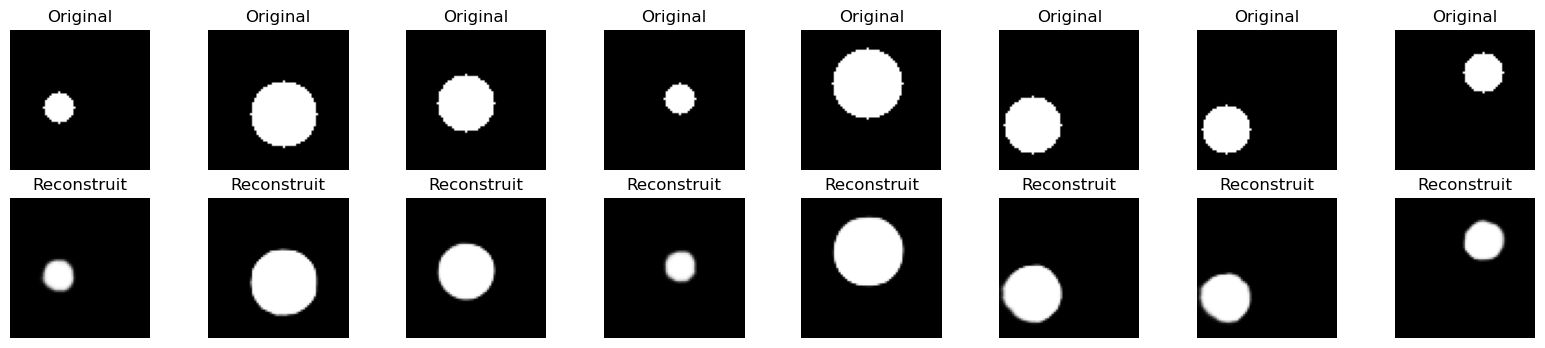

In [36]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

In [ ]:
2.Voici l'amélioration du modèle convolutionnel 



Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - loss: 0.2331 - val_loss: 0.1933
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 58s 62ms/step - loss: 0.1891 - val_loss: 0.1836
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 61ms/step - loss: 0.1844 - val_loss: 0.1811
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 58s 62ms/step - loss: 0.1822 - val_loss: 0.1769
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step - loss: 0.1803 - val_loss: 0.1787
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - loss: 0.1793 - val_loss: 0.1752
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.1790 - val_loss: 0.1752
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 58s 62ms/step - loss: 0.1788 - val_loss: 0.1742
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.1778 - val_loss: 0.1741
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.1769 - val_loss: 0.1727
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - loss: 0.1766 - val_loss: 0.1731
Epoch 12/20
938/938 ━━━━━━━━━━

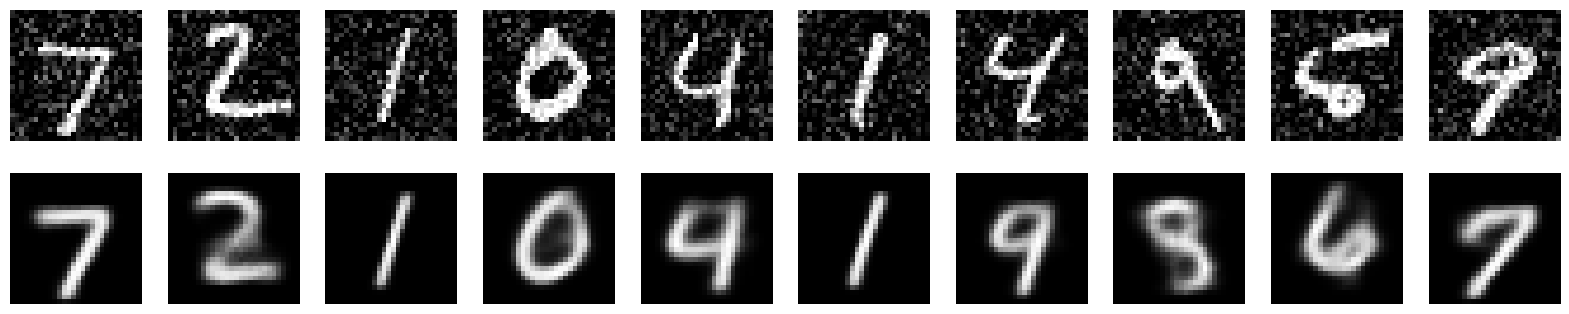

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GaussianNoise, BatchNormalization, Dropout, LeakyReLU

# Fonction pour ajouter du bruit manuellement
def add_noise(image, noise_factor=0.2):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0.0, 1.0)

# Chargement des données MNIST
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
train_data = train_data.astype("float32") / 255.0
test_data = test_data.astype("float32") / 255.0

# Reshape pour correspondre aux entrées CNN
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

# Ajout de bruit aux images
noisy_train_data = np.array([add_noise(img) for img in train_data])
noisy_test_data = np.array([add_noise(img) for img in test_data])

# Définition du modèle amélioré
input_img = layers.Input(shape=(28, 28, 1))
noisy_input = GaussianNoise(0.2)(input_img)

# Encodeur amélioré
x = layers.Conv2D(32, (3,3), padding='same')(noisy_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = Dropout(0.3)(x)

x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur amélioré
x = layers.Dense(7*7*64, activation='relu')(latent)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

# Compilation du modèle
autoencoder_conv = models.Model(input_img, x)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')

# Entraînement du modèle
autoencoder_conv.fit(noisy_train_data, train_data, epochs=20, batch_size=64, validation_data=(noisy_test_data, test_data))

# Test du modèle sur des images bruitées
decoded_imgs = autoencoder_conv.predict(noisy_test_data)

# Affichage des résultats
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Image bruitée
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(noisy_test_data[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    # Image reconstruite
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()


In [ ]:
3. OUI, augmenter la taille de l'espace latent peut être nécessaire pour améliorer la capacité du modèle à capturer des représentations plus complexes des images. 

En effet , si les images à traiter sont simples et bien structurées, un espace latent de petite taille peut suffire,
car il peut capturer l'essentiel de l'information. Cependant, si les images sont plus complexes ou bruitées,
un espace latent trop petit risque de ne pas capturer suffisamment de détails, 
ce qui entraînerait une mauvaise reconstruction.
Dans ce cas, augmenter la taille de l'espace latent permettrait au modèle de mieux apprendre les caractéristiques des images complexes. 
Toutefois, il est important de ne pas rendre l'espace latent trop grand, car cela peut entraîner un sur-apprentissage,
où le modèle s'adapte trop aux données d'entraînement et perd sa capacité à généraliser.